In [45]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

In [46]:
import yfinance as yf


In [47]:
def get_pair(name):
    curr = yf.Ticker(name)
    hist = curr.history(period = 'max')
    return (hist)

In [48]:
df = get_pair('VGT') #data pull
df.reset_index(inplace = True)
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2004-01-30,41.81,42.24,41.81,42.10,117600,0.0,0
1,2004-02-02,42.12,42.13,41.89,42.13,65400,0.0,0
2,2004-02-03,41.86,41.88,41.70,41.88,231100,0.0,0
3,2004-02-04,40.74,40.74,40.61,40.61,51000,0.0,0
4,2004-02-05,40.91,40.91,40.61,40.82,2600,0.0,0
...,...,...,...,...,...,...,...,...
4238,2020-11-30,333.24,335.50,328.80,335.33,390300,0.0,0
4239,2020-12-01,337.55,339.93,335.83,338.11,718700,0.0,0
4240,2020-12-02,336.83,338.04,334.14,337.70,363300,0.0,0
4241,2020-12-03,338.31,340.25,337.24,337.91,288400,0.0,0


In [49]:
stock = get_pair('AAPL') #data pull
stock.reset_index(inplace = True)
stock

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1980-12-12,0.10,0.10,0.10,0.10,469033600,0.0,0.0
1,1980-12-15,0.10,0.10,0.10,0.10,175884800,0.0,0.0
2,1980-12-16,0.09,0.09,0.09,0.09,105728000,0.0,0.0
3,1980-12-17,0.09,0.09,0.09,0.09,86441600,0.0,0.0
4,1980-12-18,0.09,0.09,0.09,0.09,73449600,0.0,0.0
...,...,...,...,...,...,...,...,...
10076,2020-11-30,116.97,120.97,116.81,119.05,169410200,0.0,0.0
10077,2020-12-01,121.01,123.47,120.01,122.72,128166800,0.0,0.0
10078,2020-12-02,122.02,123.37,120.89,123.08,89004200,0.0,0.0
10079,2020-12-03,123.52,123.78,122.21,122.94,78967600,0.0,0.0


In [50]:
d2 = pd.merge(df, stock, on = 'Date', how = 'inner')
d2 = d2[['Date','Close_x','Close_y']]
d2.columns = ['Date', 'ETF', 'Apple']
d2

,Date,ETF,Apple
0,2004-01-30,42.10,0.34
1,2004-02-02,42.13,0.34
2,2004-02-03,41.88,0.34
3,2004-02-04,40.61,0.33
4,2004-02-05,40.82,0.34
...,...,...,...
4238,2020-11-30,335.33,119.05
4239,2020-12-01,338.11,122.72
4240,2020-12-02,337.70,123.08
4241,2020-12-03,337.91,122.94


In [51]:
def plotter(df, x, y): 
    plt.figure(figsize = (20,10))
    for i in range(0, len(y)):
        plt.plot(df[x], df[y[i]], label = y[i])
    plt.grid()
    plt.legend()
    plt.show()

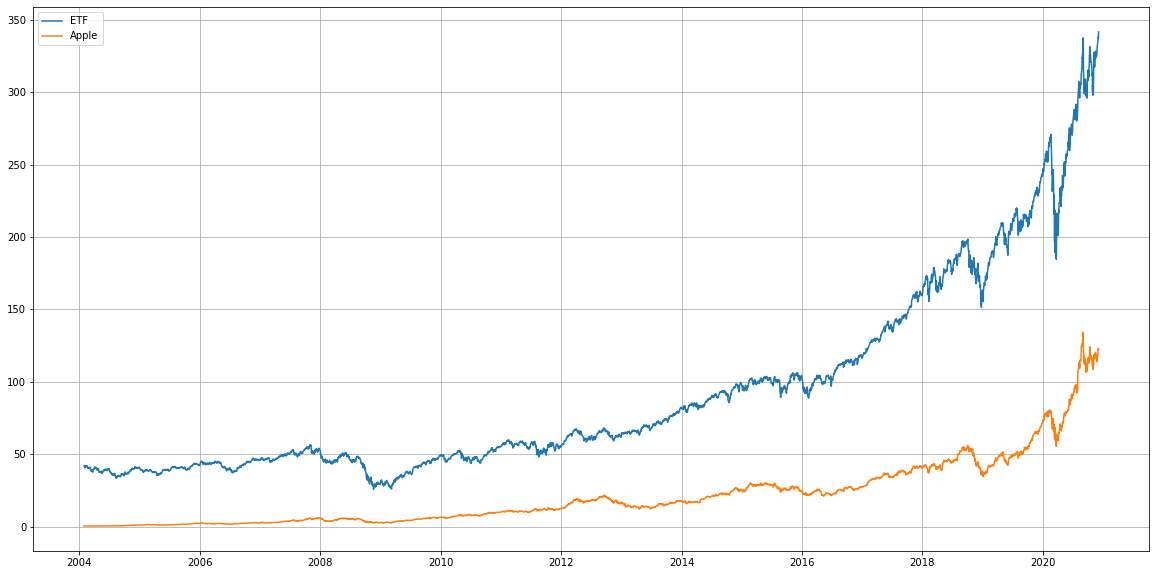

In [52]:
pair = d2
plotter(pair, 'Date', ['ETF','Apple'])

In [53]:
def gen_z_score(lookback, df, on_column): 
    df["Mean"] = df[on_column].rolling(lookback).mean()
    df["Std"] = df[on_column].rolling(lookback).std()
    df[on_column + " Z Score"] = (df[on_column] - df["Mean"])/df["Std"]
    return(df)

In [54]:
pair['Diff'] = pair['ETF'] - pair['Apple']
pair_z = gen_z_score(30, pair, 'Diff')

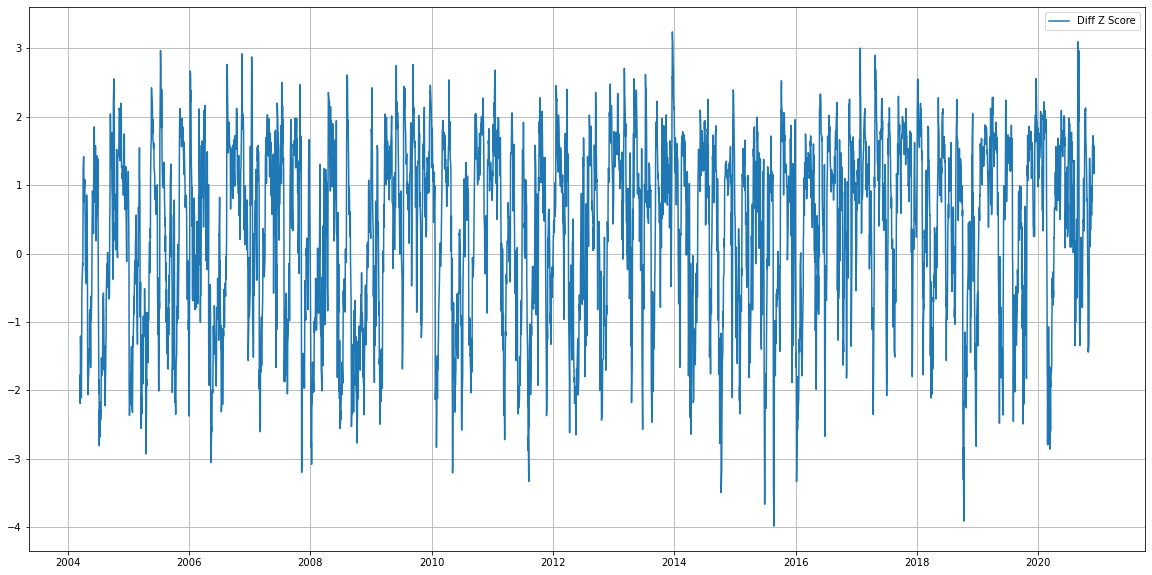

In [55]:
plotter(pair_z, 'Date', ['Diff Z Score'])

In [68]:


def backtesterV2(backtest, entry, z_key, underlying_key):
    backtest.reset_index(inplace = True, drop = True)
    backtest['Pos'] = 0 
    backtest['Tick PnL'] = 0
    backtest['Tick Change'] = backtest[underlying_key].diff()


    for i in range(1, len(backtest)): 
        if backtest.iloc[i][z_key] > entry: 
            backtest.loc[i, 'Pos'] = -1
        elif backtest.iloc[i][z_key] < -entry: 
            backtest.loc[i, 'Pos'] = 1


        if backtest.iloc[i-1]['Pos'] != 0: 
            backtest.loc[i,'Tick PnL'] = backtest.iloc[i]['Pos']*backtest.iloc[i]['Tick Change'] + (backtest.iloc[i-1]['Pos'] - backtest.iloc[i]['Pos'])* backtest.iloc[i]['Tick Change']

    backtest['Cum PnL'] = backtest['Tick PnL'].cumsum()
    
    return(backtest)

In [56]:
def backtester(backtest, entry, z_key, underlying_key):
    backtest["Position"] = 0
    mask = backtest[z_key] >= entry
    backtest.loc[mask, "Position"] = 1 
    mask2 = backtest[z_key] <= -entry
    backtest.loc[mask2, "Position"] = -1 

    backtest["Tick Change"] = backtest[underlying_key].diff(1)
    backtest["Tick PnL"] = backtest["Tick Change"] * backtest["Position"]
    backtest["Cum PnL"] = backtest["Tick PnL"].cumsum()
    
    return(backtest)


<ipython-input-68-fabadffdb663>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backtest['Pos'] = 0
<ipython-input-68-fabadffdb663>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  backtest['Tick PnL'] = 0
<ipython-input-68-fabadffdb663>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

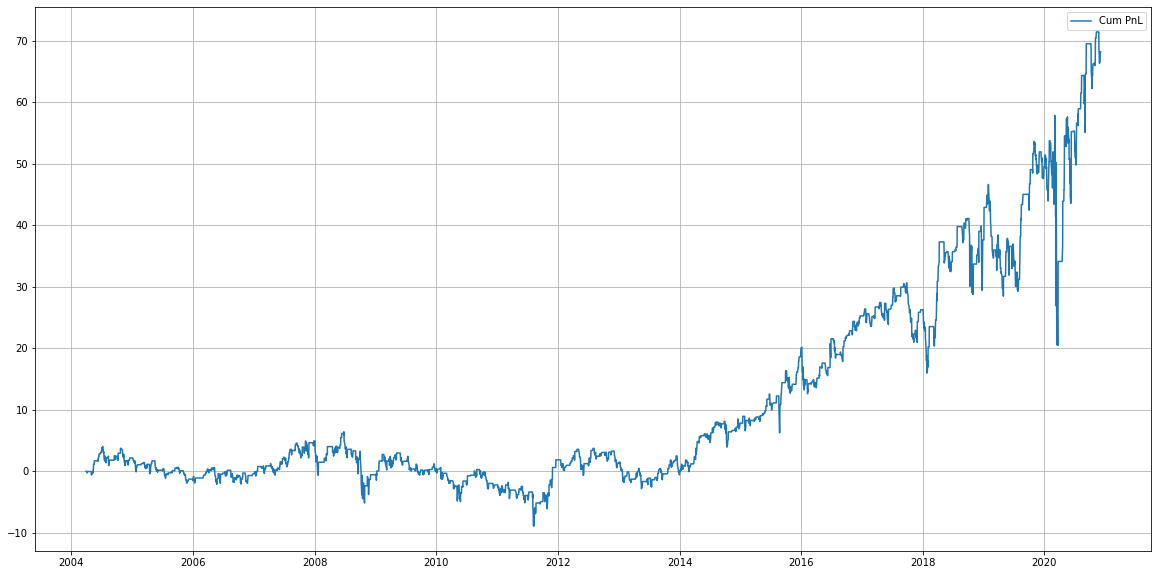

In [74]:
btest = backtesterV2(pair_z[40:], 1.25, 'Diff Z Score', 'Diff')
plotter(btest, 'Date', ['Cum PnL'])

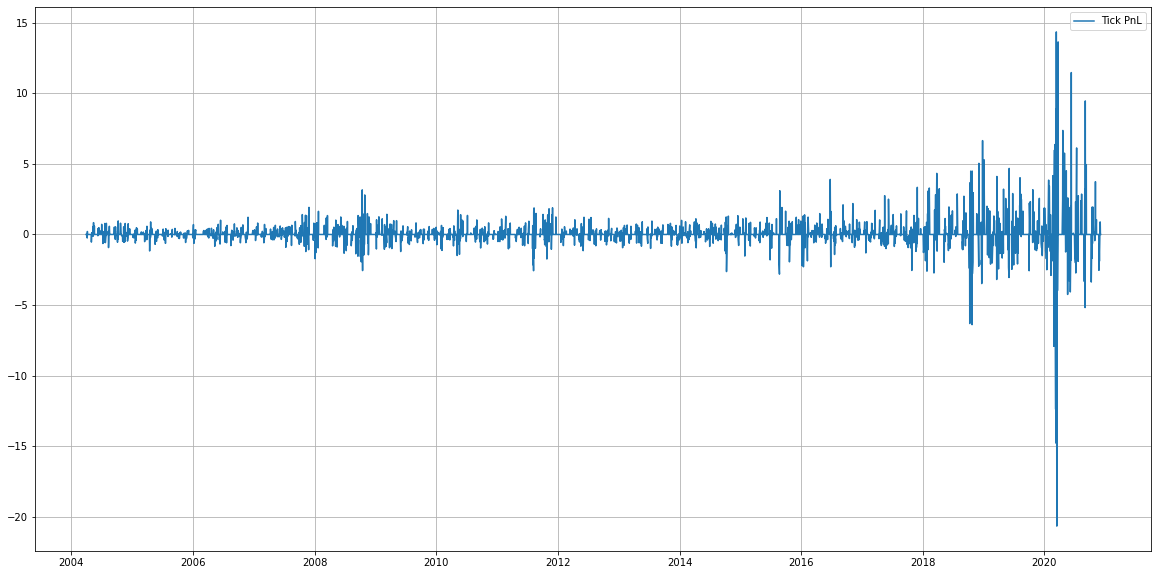

In [75]:
plotter(btest, 'Date',['Tick PnL'])

In [76]:
pair_z

,Date,ETF,Apple,Diff,Mean,Std,Diff Z Score
0,2004-01-30,42.10,0.34,41.76,NaN,NaN,NaN
1,2004-02-02,42.13,0.34,41.79,NaN,NaN,NaN
2,2004-02-03,41.88,0.34,41.54,NaN,NaN,NaN
3,2004-02-04,40.61,0.33,40.28,NaN,NaN,NaN
4,2004-02-05,40.82,0.34,40.48,NaN,NaN,NaN
...,...,...,...,...,...,...,...
4238,2020-11-30,335.33,119.05,216.28,203.980000,7.773605,1.582277
4239,2020-12-01,338.11,122.72,215.39,204.325667,8.047191,1.374931
4240,2020-12-02,337.70,123.08,214.62,204.683000,8.262759,1.202625
4241,2020-12-03,337.91,122.94,214.97,205.069000,8.468203,1.169197


In [78]:
btest.describe()

,ETF,Apple,Diff,Mean,Std,Diff Z Score,Pos,Tick PnL,Tick Change,Cum PnL
count,4203.000000,4203.000000,4203.000000,4203.000000,4203.000000,4203.000000,4203.000000,4203.000000,4202.000000,4203.000000
mean,93.093659,21.480521,71.613138,71.022097,1.734898,0.364363,-0.160837,0.016227,0.042903,11.374378
std,67.158557,23.554314,44.339100,43.552020,1.833091,1.293650,0.654002,0.937402,1.283534,17.197269
min,25.620000,0.390000,23.160000,25.961000,0.278444,-3.982482,-1.000000,-20.660000,-20.660000,-8.910000
25%,45.460000,4.070000,40.830000,40.868333,0.816688,-0.613704,-1.000000,0.000000,-0.320000,-0.030000
50%,63.270000,14.270000,47.600000,47.288667,1.163587,0.669891,0.000000,0.000000,0.050000,2.440000
75%,113.260000,28.640000,87.230000,87.112667,1.967388,1.396216,0.000000,0.000000,0.440000,21.200000
max,341.700000,133.950000,219.450000,205.609333,21.361176,3.240806,1.000000,14.350000,14.350000,71.430000
